In [73]:
import pandas as pd
import scipy.stats as st
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import math
from statsmodels.graphics.factorplots import interaction_plot
import sklearn

In [2]:
ex_14_3 = pd.read_excel('hw5.xlsx', sheet_name='14.3')
ex_14_8 = pd.read_excel('hw5.xlsx', sheet_name='14.8')

## Chapter 14

### 14.2
-- Text response

### 14.3

In [3]:
# transform data
ex_14_3.set_index('Student', inplace=True)
df_melt = ex_14_3.melt(value_name='Score', var_name='Method')

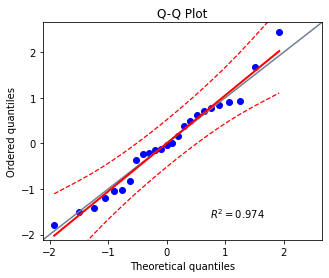

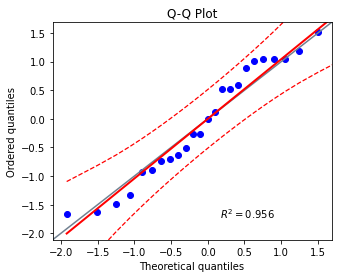

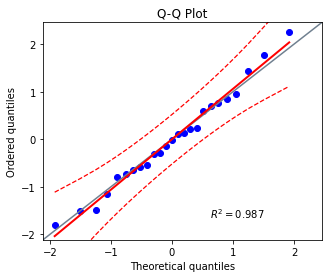

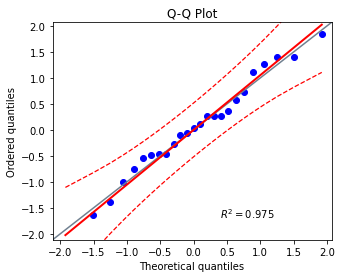

In [4]:
# check normality
for strain in df_melt['Method'].unique():
    ax = pg.qqplot(df_melt[df_melt['Method'] == strain]['Score'], dist='norm')

<AxesSubplot:>

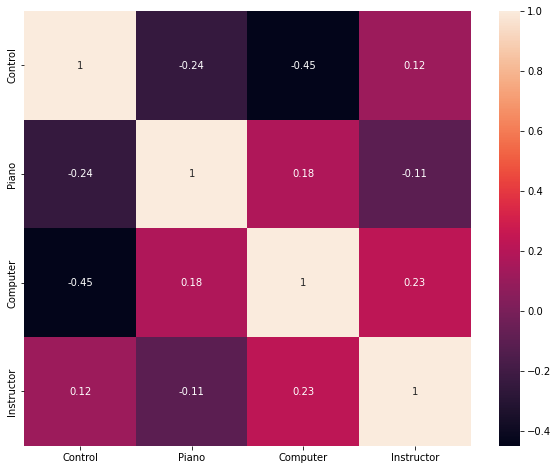

In [5]:
# check for independence/covariance
corr = ex_14_3.corr()

f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True)

In [6]:
# set model and run ANOVA
model = ols('Score ~ C(Method)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Method),3.0,727.2355,242.411833,24.437128,7.806630e-12
Residual,96.0,952.3024,9.919817,NaN,NaN


In [7]:
# get totals for final write-out

df_total = anova_table['df'].sum()
ss_total = round(anova_table['sum_sq'].sum(), 4)
print(f"Total df: {df_total}")
print(f"Total SS: {ss_total}")

Total df: 99.0
Total SS: 1679.5379


In [8]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     24.44
Date:                Sun, 08 May 2022   Prob (F-statistic):           7.81e-12
Time:                        18:48:00   Log-Likelihood:                -254.58
No. Observations:                 100   AIC:                             517.2
Df Residuals:                      96   BIC:                             527.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [9]:
# run Fisher's LSD for pairwise differences

df_treat = anova_table['df'][0]
df_err = anova_table['df'][0]

n = len(ex_14_3)

alpha = 0.05

t_a2 = abs(st.t.ppf(alpha / 2, df_total))
print(f"T-val = {t_a2}")

# if n is not equal
# lsd = t_a2 * math.sqrt(s_w**2 * ( (1 / n1) + (1 / n2)))

# if n is equal
lsd = t_a2 * math.sqrt((2 * anova_table['mean_sq'][1])/ n)

print(f"lsd: {lsd}")

teach_means = ex_14_3.mean().sort_values(ascending=False).to_frame()
# teach_means
teach_means.drop(index=['Control'], inplace=True)

T-val = 1.9842169515086832
lsd: 1.7676080549471325


In [10]:
pairs = pd.DataFrame()
diff_df = pd.DataFrame()
calcs = pd.DataFrame()

# iterate through different teaching methods and determine if significance between 
i = 0
while i < len(teach_means):
    j = i + 1
    while j < len(teach_means):
        pair_dict = {
            "pair": f"{teach_means.index[i]} and {teach_means.index[j]}"
        }
        pair_df = pd.DataFrame(pair_dict, index=[len(pairs)])
        pairs = pd.concat([pairs, pair_df])
        calc = pd.DataFrame([teach_means[0][i] - teach_means[0][j]])
        # print(f"{calc}")
        calcs = pd.concat([calcs, calc], ignore_index=True)
        j += 1
    i += 1

# concat and clean up dataframes
diff_df = pd.concat([diff_df, calcs])
diff_df.rename(columns={0: 'diff_calc'}, inplace=True)
diff_df = pd.concat([diff_df, pairs], axis=1)
diff_df.set_index('pair', inplace=True)

# test/calculate significance
diff_df["sig_val_test"] = diff_df["diff_calc"].apply(lambda x: "significant" if x > lsd else "not significant")
diff_df

,diff_calc,sig_val_test
pair,,
Instructor and Computer,2.636,significant
Instructor and Piano,3.608,significant
Computer and Piano,0.972,not significant


In [11]:
type(pd.Series(ex_14_8.Age.unique()))

pandas.core.series.Series

### 14.8

In [12]:
# calculate means across all groups
att_sp_means = ex_14_8.groupby(['Age', 'Product'])['Time'].agg('mean')

# clean up table to make it legible
att_sp_means = att_sp_means.unstack().reset_index().T.rename(columns=pd.Series(ex_14_8.Age.unique())).drop('Age')
att_sp_means

,5-6 yrs,7-8 yrs,9-10 yrs
Product,,,
Breakfast cereal,22.9,19.6,21.9
Video game,23.1,30.5,45.6


In [13]:
mu_hat = 45.6

pd.DataFrame(att_sp_means.loc[f'Video game', ['5-6 yrs', '7-8 yrs']] - mu_hat)

,Video game
5-6 yrs,-22.5
7-8 yrs,-15.1


In [14]:
pd.DataFrame(att_sp_means.loc[f'Breakfast cereal', ['9-10 yrs']] - mu_hat)

,Breakfast cereal
9-10 yrs,-23.7


In [55]:
age_groups = ['5-6 yrs', '9-10 yrs']
group_means = []

i = 0
while i < len(age_groups):
    sel_mean = att_sp_means.iloc[i].values[i]
    sel_group = age_groups[i]
    sel_att = att_sp_means.index.values
    # print(f"{sel_att} - {sel_group}: {sel_mean}")
    group_means.append(sel_mean)
    i += 1

group_means


[22.9, 30.5]

In [67]:

i = 0
while i < len(att_sp_means['5-6 yrs'].values) - 1:
    val1 = att_sp_means['5-6 yrs'].values[i] - att_sp_means['5-6 yrs'].values[i + 1]
    i += 1

In [68]:
att_sp_means['9-10 yrs'].values

i = 0
while i < len(att_sp_means['9-10 yrs'].values) - 1:
    val2 = att_sp_means['9-10 yrs'].values[i] - att_sp_means['9-10 yrs'].values[i + 1]
    i += 1

In [69]:
t_b_int1 = val1 - val2
t_b_int1

23.5

In [70]:
i = 0
while i < len(att_sp_means['7-8 yrs'].values) - 1:
    val3 = att_sp_means['7-8 yrs'].values[i] - att_sp_means['7-8 yrs'].values[i + 1]
    i += 1

In [72]:
t_b_int2 = val3 - val2
t_b_int2

12.800000000000004

In [18]:
age_asp_means = att_sp_means.T.mean().to_frame()
age_asp_means.columns = ['Means']
age_asp_means

,Means
Product,
Breakfast cereal,21.466667
Video game,33.066667


In [19]:
prod_asp_means = att_sp_means.mean().to_frame()
prod_asp_means.columns = ['Means']
prod_asp_means

,Means
5-6 yrs,23.00
7-8 yrs,25.05
9-10 yrs,33.75


In [60]:
multi_model = ols('Time ~ C(Age) + C(Product) + C(Age):C(Product)', data=ex_14_8).fit()
anova_table = sm.stats.anova_lm(multi_model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Age),1303.033333,2.0,4.428739,0.016557
C(Product),2018.400000,1.0,13.720242,0.000500
C(Age):C(Product),1384.300000,2.0,4.704947,0.013073
Residual,7944.000000,54.0,NaN,NaN


### 14.9

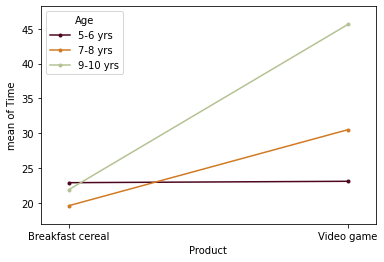

In [76]:
# https://www.reneshbedre.com/blog/anova.html

fig = interaction_plot(x=ex_14_8['Product'], trace=ex_14_8['Age'], response=ex_14_8['Time'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.show()

### 14.10

In [111]:
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     6.398
Date:                Sun, 08 May 2022   Prob (F-statistic):           9.82e-05
Time:                        20:29:50   Log-Likelihood:                -231.71
No. Observations:                  60   AIC:                             475.4
Df Residuals:                      54   BIC:                             488.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

<AxesSubplot:>

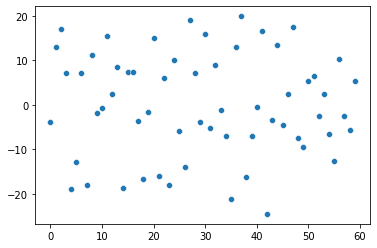

In [108]:
sns.scatterplot(data=multi_model.resid)

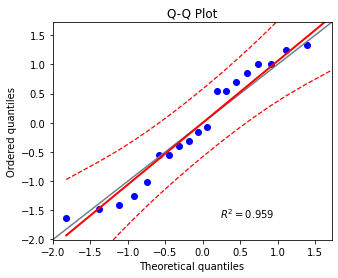

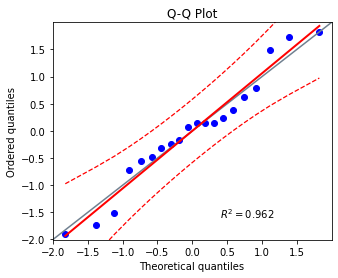

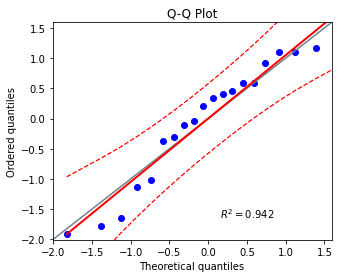

In [113]:
for age in ex_14_8['Age'].unique():
    ax = pg.qqplot(ex_14_8[ex_14_8['Age'] == age]['Time'], dist='norm')

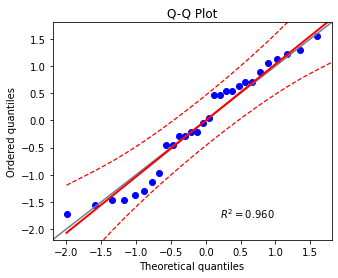

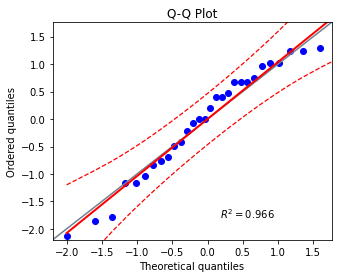

In [114]:
for age in ex_14_8['Product'].unique():
    ax = pg.qqplot(ex_14_8[ex_14_8['Product'] == age]['Time'], dist='norm')

### 14.14

In [115]:
pg.pairwise_tukey(data=ex_14_8, dv='Time', between='Age')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,5-6 yrs,7-8 yrs,23.00,25.05,-2.05,4.461669,-0.459469,0.890384,-0.142410
1,5-6 yrs,9-10 yrs,23.00,33.75,-10.75,4.461669,-2.409412,0.049650,-0.746785
2,7-8 yrs,9-10 yrs,25.05,33.75,-8.70,4.461669,-1.949943,0.134206,-0.604375


In [116]:
pg.pairwise_tukey(data=ex_14_8, dv='Time', between='Product')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Breakfast cereal,Video game,21.466667,33.066667,-11.6,3.495701,-3.318362,0.001568,-0.84567
